In [1]:
import os
current_directory = os.getcwd()
print(current_directory)
dir_base = os.path.join(current_directory,'Dataset')
print(dir_base)

/home/ladans/DNN/Project
/home/ladans/DNN/Project/Dataset


In [3]:
import pandas as pd
import glob
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Input, Concatenate
from keras.layers import Flatten, RepeatVector

# Directory containing CSV files
data_dir = dir_base

# Initialize an empty DataFrame
all_data = pd.DataFrame()

# Iterate over each file in the directory
for file_path in glob.glob(os.path.join(data_dir, "*.csv")):
    # Extract stock symbol from the filename
    stock_symbol = os.path.basename(file_path).split('.')[0]
    
    # Load the CSV
    df = pd.read_csv(file_path)
    
    # Add a column for the stock symbol
    df['Stock_Symbol'] = stock_symbol
    
    # Optional: Select only necessary columns
    df = df[['Date', 'Open', 'Close', 'Stock_Symbol']]
    
    # Append to the main DataFrame
    all_data = pd.concat([all_data, df], ignore_index=True)

# Sort by date and stock symbol if needed
all_data = all_data.sort_values(['Stock_Symbol', 'Date']).reset_index(drop=True)

# Encode stock symbols
encoder = LabelEncoder()
all_data['Stock_Index'] = encoder.fit_transform(all_data['Stock_Symbol'])
all_data.head()

,Date,Open,Close,Stock_Symbol,Stock_Index
0,2012-09-04,95.108574,96.424286,AAPL,0
1,2012-09-05,96.510002,95.747147,AAPL,0
2,2012-09-06,96.167145,96.610001,AAPL,0
3,2012-09-07,96.864288,97.205711,AAPL,0
4,2012-09-10,97.207146,94.677139,AAPL,0


In [4]:
# Parameters
sequence_length = 30  # Days in each input sequence
test_ratio = 0.2

# Initialize lists for inputs and outputs
X, y, stock_indices = [], [], []

for stock in all_data['Stock_Symbol'].unique():
    stock_data = all_data[all_data['Stock_Symbol'] == stock]
    
    # Normalize 'Close' price data for this stock
    prices = stock_data['Close'].values
    normalized_prices = prices / prices[0] - 1  # Normalize with respect to the first value
    
    # Create sequences of length `sequence_length`
    for i in range(len(normalized_prices) - sequence_length):
        X.append(normalized_prices[i: i + sequence_length])
        y.append(normalized_prices[i + sequence_length])
        stock_indices.append(stock_data['Stock_Index'].iloc[0])  # Same index for the whole stock

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
stock_indices = np.array(stock_indices)

# Train-test split
train_size = int(len(X) * (1 - test_ratio))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
stock_indices_train, stock_indices_test = stock_indices[:train_size], stock_indices[train_size:]
print(train_size)

3929


In [5]:
#Model:
# Number of unique stocks and embedding dimensions
num_stocks = len(all_data['Stock_Symbol'].unique())
embedding_size = 8

# Define inputs
price_input = Input(shape=(sequence_length, 1), name='price_input')
stock_input = Input(shape=(1,), name='stock_input')


# Embedding layer for stock index
stock_embedding = Embedding(input_dim=num_stocks, output_dim=embedding_size, input_length=1)(stock_input)
stock_embedding = Flatten()(stock_embedding)  # Flatten to 2D (batch_size, embedding_size)
stock_embedding = RepeatVector(sequence_length)(stock_embedding)  # Replicate to match LSTM input shape

# Concatenate price input with stock embedding
merged_input = Concatenate(axis=2)([price_input, stock_embedding])


# LSTM layer
lstm_out = LSTM(units=256)(merged_input)

# Output layer
output = Dense(units=1)(lstm_out)

# Define and compile the model
model = Model(inputs=[price_input, stock_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit([X_train, stock_indices_train], y_train, epochs=30, batch_size=1, verbose=1)

Epoch 1/30


/opt/conda/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
W0000 00:00:1731258058.322287   62377 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/opt/conda/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['price_input', 'stock_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


3929/3929 ━━━━━━━━━━━━━━━━━━━━ 44s 11ms/step - loss: 0.0320
Epoch 2/30
3929/3929 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 0.0022
Epoch 3/30
3929/3929 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 0.0017
Epoch 4/30
3929/3929 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - loss: 0.0015
Epoch 5/30
3929/3929 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - loss: 0.0015
Epoch 6/30
3929/3929 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - loss: 0.0015
Epoch 7/30
3929/3929 ━━━━━━━━━━━━━━━━━━━━ 39s 10ms/step - loss: 0.0012
Epoch 8/30
3929/3929 ━━━━━━━━━━━━━━━━━━━━ 34s 9ms/step - loss: 0.0013
Epoch 9/30
3929/3929 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 0.0013
Epoch 10/30
3929/3929 ━━━━━━━━━━━━━━━━━━━━ 38s 10ms/step - loss: 0.0011
Epoch 11/30
3929/3929 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - loss: 0.0012
Epoch 12/30
3929/3929 ━━━━━━━━━━━━━━━━━━━━ 40s 10ms/step - loss: 0.0010
Epoch 13/30
3929/3929 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - loss: 9.3197e-04
Epoch 14/30
3929/3929 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 9.3007e-04
Epoch 15/30


In [ ]:
# Save the model
model.save("stock_price_prediction_model.h5")
###################################################################
from keras.models import load_model
model = load_model("stock_price_prediction_model.h5")
##################################################################

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
MAE: 0.01555167069951147
MSE: 0.0005004598665175244
RMSE: 0.02237096033963505
MAPE: 76.46615729642133 %


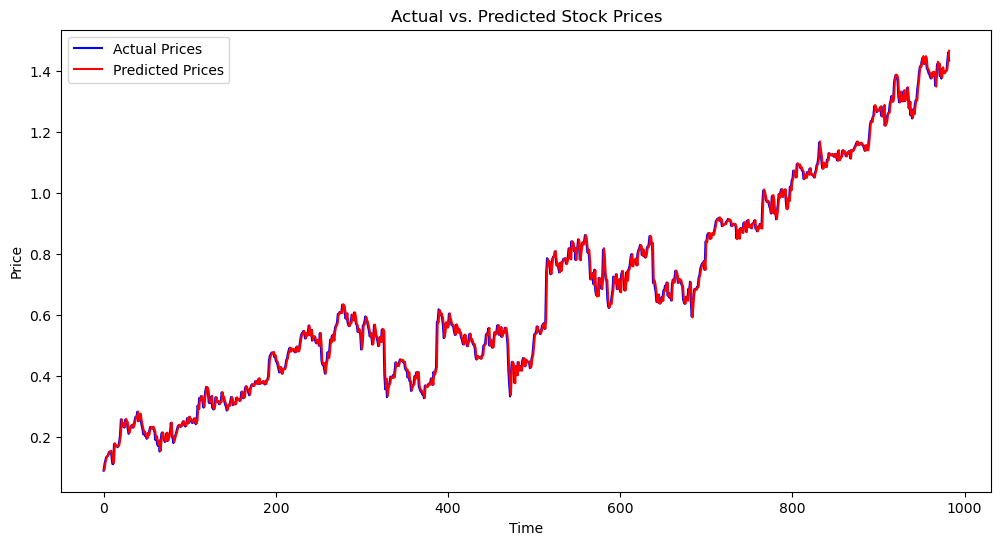

MAE for stock MSFT (ID: 3): 0.01555167069951147


In [6]:
#Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming `model` is your trained model, `X_test` is your test data input
predicted_prices = model.predict([X_test, stock_indices_test])

# Calculate MAE and MSE
mae = mean_absolute_error(y_test, predicted_prices)
mse = mean_squared_error(y_test, predicted_prices)
rmse = mean_squared_error(y_test, predicted_prices, squared=False)  # Square root of MSE for RMSE

# Print results
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

mape = np.mean(np.abs((y_test - predicted_prices) / y_test)) * 100
print("MAPE:", mape, "%")

import matplotlib.pyplot as plt

# Plot predictions and actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices", color="blue")
plt.plot(predicted_prices, label="Predicted Prices", color="red")
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.show()
#########################################################
for stock_id in np.unique(stock_indices_test):
    stock_mask = stock_indices_test == stock_id
    stock_symbol = encoder.inverse_transform([stock_id])[0]
    stock_mae = mean_absolute_error(y_test[stock_mask], predicted_prices[stock_mask])
    print(f"MAE for stock {stock_symbol} (ID: {stock_id}): {stock_mae}")
#################################################################

In [7]:
# # Predict the next price for a new sequence from AAPL
# array_30_values = X_test[-1]

# new_sequence = array_30_values.reshape((1, sequence_length))

# # Find the encoded index for AAPL
# stock_index = encoder.transform(['AAPL'])

# # Predict
# predicted_price = model.predict([new_sequence, stock_index])
# #Denormalize
# print("Predicted next price for AAPL:", predicted_price[0][0])
##############################################################
# Predict the next price for a new sequence from AAPL
array_30_values = X_test[-1]
new_sequence = array_30_values.reshape((1, sequence_length))

# Find the encoded index for AAPL
stock_index = encoder.transform(['AAPL'])

# Predict (normalized value)
predicted_normalized_price = model.predict([new_sequence, stock_index])

# Reverse normalization
# Retrieve the first price of the sequence used to normalize this stock
original_starting_price = all_data[(all_data['Stock_Symbol'] == 'AAPL')]['Close'].values[0]
predicted_price_original_scale = (predicted_normalized_price[0][0] + 1) * original_starting_price

print("Predicted next price for AAPL (original scale):", predicted_price_original_scale)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted next price for AAPL (original scale): 237.82776991742895
